# Working with Prompts/Prompt Template Assets


This notebook should use Runtime 22.2 & Python 3.10 or greater runtime environment. If you are viewing this in Watson Studio and do not see Python 3.10.x in the upper right corner of your screen, please update the runtime now. 

The notebook will create a summarization prompt template asset in a given project, configure OpenScale to monitor that PTA and evaluate generative ai quality metrics and model health metrics. The notebook then promotes the prompt template asset to space and does the same evaluation.

If users wish to execute this notebook for task types other than summarization, please consult [this](https://github.com/IBM/watson-openscale-samples/blob/main/IBM%20Cloud/WML/notebooks/watsonx/README.md) document for guidance on evaluating prompt templates for the available task types.

Note : User can search for `EDIT THIS` and fill the inputs needed

## Prerequisite

* It requires service credentials for IBM Watson OpenScale:
* Requires a CSV file containing the test data that needs to be evaluated
* Requires the ID of project in which you want to create the prompt template asset.
* Requires the ID of space to which you want to promote the prompt template asset.

### Contents

- [Setup](#settingup)
- [Create Prompt template](#prompt)
- [Prompt Setup](#ptatsetup)
- [Risk evaluations for prompt template asset subscription](#evaluate)
- [Display the Model Risk metrics](#mrmmetric)
- [Display the Generative AI Quality metrics](#genaimetrics)
- [Plot rougel and rougelsum metrics against records](#plotproject)
- [See factsheets information](#factsheetsspace)
- [Evaluate prompt template from space](#evaluatespace)
- [Promote prompt template asset to space](#promottospace)
- [Create deployment for prompt template asset in space](#ptadeployment)
- [Setup the prompt template asset in space](#ptaspace)
- [Score the model and configure monitors](#score)
- [Plot rougel and rougelsum metrics against records for production subscription](#plotspace)
- [See factsheets information from space](#factsheetsproject)

## Setup <a name="settingup"></a>

In [1]:
!pip install --upgrade ibm-watson-openscale | tail -n 1
!pip install --upgrade ibm-watson-ai | tail -n 1
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement ibm-watson-ai (from versions: none)
ERROR: No matching distribution found for ibm-watson-ai


Note: you may need to restart the kernel to use updated packages.

### Provision services and configure credentials

If you have not already, provision an instance of IBM Watson OpenScale using the [OpenScale link in the Cloud catalog](https://cloud.ibm.com/catalog/services/watson-openscale).

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**NOTE:** You can also get OpenScale `API_KEY` using IBM CLOUD CLI.

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [2]:
use_cpd = False
IAM_URL="https://iam.cloud.ibm.com"
DATAPLATFORM_URL = "https://api.dataplatform.cloud.ibm.com"
SERVICE_URL = "https://aiopenscale.cloud.ibm.com"
CLOUD_API_KEY = "<apikey>" # YOUR_CLOUD_API_KEY


WML_CREDENTIALS = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey": CLOUD_API_KEY
}

Uncomment the code and run the below cell only if you are running your notebook on a CPD cluster.

## Read project id from user

In order to set up a development type subscription, the PTA must be within the project. Please supply the project ID where the PTA needs to be created.

In [3]:
project_id = "<project_id>" # YOUR_PROJECT_ID

## Read space id from user

User can use an existing space or can create a new space to promote the model. User should choose any of these options with the below variable.

In [4]:
use_existing_space = True # Set it as False if user wants to create a new space

In [5]:
import json
from ibm_watsonx_ai import APIClient

wx_ai_client = APIClient(WML_CREDENTIALS)
wx_ai_client.version

'1.3.39'

### Below details are required only if user choose to use an existing space

In order to use an existing space, User can directly add the space id in the below cell

In [6]:
wx_ai_client.spaces.list()

,ID,NAME,CREATED
0,cd33aff1-032b-4256-9afd-566d7aec6817,runtime_evaluation_deployment_space_2,2025-10-01T07:07:31.887Z
1,888ea269-8065-4573-b755-30e6ab163afc,test3,2025-10-01T02:49:41.151Z
2,054a66eb-932c-4847-b0b1-cc390f287302,runtime_evaluation_deployment_space,2025-09-30T13:04:27.032Z
3,e5e284e1-ac12-48d9-82cb-be755d3f88c0,Lenovo Agent Deployment Space,2025-08-13T13:32:54.795Z
4,84057519-41ec-47a8-beb7-7c225b75b7a9,Abilis Deployment Space,2025-08-01T02:18:49.761Z
...,...,...,...
72,ca19c4f6-d472-4456-b4d7-b1390f51903e,openscale-express-path-a4449307-d6b7-4c08-940e...,2023-01-29T21:02:34.013Z
73,0899955a-0846-47f3-89c2-2ebbd0eb40b5,lab deployment space,2023-01-29T20:50:19.569Z
74,abe99620-0248-43db-a08c-6cf116312713,test-catalog,2022-06-24T11:28:54.933Z
75,fe431c00-1280-4321-a9a9-fa21351d135a,openscale-express-path-preprod-0a6478e8-614f-4...,2022-06-02T04:57:23.306Z


In [9]:
existing_space_id = "<space_id>" # YOUR_SPACE_ID

### Below details are required only if user choose to create a new space

In [10]:
space_name = "runtime_evaluation_deployment_space_2" # YOUR_SPACE_NAME

Tip: `WML_INSTANCE_NAME`, `WML_CRN` and `COS_RESOURCE_CRN` are required only if you are pointing to your cloud openscale instance, Your `WML_INSTANCE_NAME` and `WML_CRN` can be read from the [Cloud console](https://cloud.ibm.com/resources). From that page, goto `Resours list`, Copy the name of your WML instance listed there. Select the row corresponding to your WML instance, and copy the CRN displayed in the popup on the right side of the page

In [11]:
#####################################################################################
# Paste your WML_INSTANCE_NAME, WML CRN in the following field and then run this cell.
######################################################################################
WML_INSTANCE_NAME =  "" # YOUR_WML_INSTANCE_NAME
WML_CRN =  "" # YOUR_WML_CRN

In next cell, you will need to paste COS_RESOURCE_CRN. If you haven't worked with COS yet please visit [getting started with COS tutorial](https://cloud.ibm.com/docs/cloud-object-storage?topic=cloud-object-storage-getting-started-cloud-object-storage).
You can find COS_RESOURCE_CRN variable in Service Credentials in menu of your COS instance.

In [12]:
COS_RESOURCE_CRN = " "

### Setting up the space

In [13]:
if use_existing_space == True:
    space_id = existing_space_id
else:
    if use_cpd:
        space_meta_data = {
            wx_ai_client.spaces.ConfigurationMetaNames.NAME : space_name,
            wx_ai_client.spaces.ConfigurationMetaNames.DESCRIPTION : 'tutorial_space'
        }
    else:
        space_meta_data = {
            wx_ai_client.spaces.ConfigurationMetaNames.NAME: space_name,
            wx_ai_client.spaces.ConfigurationMetaNames.STORAGE: {"resource_crn":COS_RESOURCE_CRN},
            wx_ai_client.spaces.ConfigurationMetaNames.COMPUTE: {"name": WML_INSTANCE_NAME, "crn": WML_CRN},
            wx_ai_client.spaces.ConfigurationMetaNames.TYPE: "wx"
        }

    space_id = wx_ai_client.spaces.store(
        meta_props=space_meta_data)["metadata"]["id"]
wx_ai_client.set.default_space(space_id)
print(space_id)

888ea269-8065-4573-b755-30e6ab163afc


## Function to create the access token

This function generates an IAM access token using the provided credentials. The API calls for creating and scoring prompt template assets utilize the token generated by this function.

In [14]:
import requests, json
def generate_access_token():
    headers={}
    if not use_cpd: 
        headers["Content-Type"] = "application/x-www-form-urlencoded"
        headers["Accept"] = "application/json"
        data = {
            "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
            "apikey": CLOUD_API_KEY,
            "response_type": "cloud_iam"
        }
        response = requests.post(IAM_URL + "/identity/token", data=data, headers=headers)
        json_data = response.json()
        iam_access_token = json_data['access_token']
    else:
        headers["Content-Type"] = "application/json"
        headers["Accept"] = "application/json"
        data = {
            "username":WOS_CREDENTIALS["username"],
            "password":WOS_CREDENTIALS["password"]
        }
        data = json.dumps(data).encode("utf-8")
        url = WOS_CREDENTIALS["url"] + "/icp4d-api/v1/authorize"
        response = requests.post(url=url, data=data, headers=headers, verify=False)
        json_data = response.json()
        iam_access_token = json_data['token']      
        
    return iam_access_token

iam_access_token = generate_access_token()

# Create Prompt template <a name="prompt"></a>

Create a prompt template for summarization task

In [15]:
if not use_cpd:
    credentials={
        "apikey": CLOUD_API_KEY,
        "url": "https://us-south.ml.cloud.ibm.com"
    }

In [16]:
from ibm_watsonx_ai.foundation_models.prompts import PromptTemplate, PromptTemplateManager
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes

prompt_mgr = PromptTemplateManager(
                credentials = credentials,
                project_id = project_id
                )

prompt_template = PromptTemplate(name="Summarise input",
                                 model_id="mistralai/mistral-large",
                                 task_ids=["summarization"],
                                 input_prefix="Human:",
                                 output_prefix="Assistant:",
                                 input_text="summarize the given content {original_text}",
                                 input_variables=['original_text'])

stored_prompt_template = prompt_mgr.store_prompt(prompt_template)
project_pta_id = stored_prompt_template.prompt_id
project_pta_id

'73dd23b8-c255-48e4-8abe-fd3bfeb13336'

# Prompt setup <a name="ptatsetup"></a>

### Configure OpenScale

In [17]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator, CloudPakForDataAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *

if use_cpd:
    authenticator = CloudPakForDataAuthenticator(
            url=WOS_CREDENTIALS['url'],
            username=WOS_CREDENTIALS['username'],
            password=WOS_CREDENTIALS['password'],
            disable_ssl_verification=True
        )
    
    wos_client = APIClient(service_url=WOS_CREDENTIALS['url'],authenticator=authenticator)
    print(wos_client.version)
else:
    service_instance_id = "" # Update this to refer to a particular service instance
    authenticator = IAMAuthenticator(apikey=CLOUD_API_KEY, url = IAM_URL)
    wos_client = APIClient(authenticator=authenticator, service_url = SERVICE_URL, service_instance_id = service_instance_id)
    print(wos_client.version)

/opt/homebrew/lib/python3.11/site-packages/ibm_watson_openscale/utils/utils.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


3.1.0


### Listing all the available datamarts

In [18]:
wos_client.data_marts.show()

None,None,False,active,2024-02-22 16:41:26.617000+00:00,2c08665d-dacd-4fe2-9035-6963dc3fb1a4


In [19]:
data_mart_id = "2c08665d-dacd-4fe2-9035-6963dc3fb1a4" # YOUR_DATAMART_ID

### Openscale instance mapping with the project

When the authentication is on CPD then we need to add additional step of mapping the `project_id/space_id` to an OpenScale instance.

In [20]:
if use_cpd:
    wos_client.wos.add_instance_mapping(                
                    service_instance_id=data_mart_id,
                    project_id=project_id
                 )
    wos_client.wos.add_instance_mapping(                
                    service_instance_id=data_mart_id,
                    space_id=space_id
                 )

### Setup the prompt template asset in project for evaluation with supported monitor dimensions

The prompt template assets from project is only supported with `development` operational space ID. Running the below cell will create a development type subscription from the prompt template asset created within the project.

The available parameters that can be passed for `execute_prompt_setup` function are:

 * `prompt_template_asset_id` : Id of prompt template asset for which subscription needs to be created.
 * `label_column` :  The name of the column containing the ground truth or actual labels.
 * `project_id` : The GUID of the project.
 * `space_id` : The GUID of the space.
 * `deployment_id` : (optional) The GUID of the deployment.
 * `operational_space_id` : The rank of the environment in which the monitoring is happening. Accepted values are `development`, `pre_production`, `production`.
 * `problem_type` : (optional) The task type to monitor for the given prompt template asset.
 * `classification_type` : The classification type `binary`/`multiclass` applicable only for `classification` problem (task) type.
 * `input_data_type` : The input data type.
 * `supporting_monitors` : Monitor configuration for the subscription to be created.
 * `background_mode` : When `True`, the promt setup operation will be executed in the background

In [21]:
label_column = "reference_summary"
operational_space_id = "development"
problem_type= "summarization"
input_data_type= "unstructured_text"


monitors = {
    "generative_ai_quality": {
        "parameters": {

            "min_sample_size": 10,
            "metrics_configuration":{                    
            }
        }
    }
}

response = wos_client.wos.execute_prompt_setup(prompt_template_asset_id = project_pta_id, 
                                                                   project_id = project_id,
                                                                   label_column = label_column, 
                                                                   operational_space_id = operational_space_id, 
                                                                   problem_type = problem_type,
                                                                   input_data_type = input_data_type, 
                                                                   supporting_monitors = monitors, 
                                                                   background_mode = False)

result = response.result
result._to_dict()




 Waiting for end of adding prompt setup 73dd23b8-c255-48e4-8abe-fd3bfeb13336 




running...
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '73dd23b8-c255-48e4-8abe-fd3bfeb13336',
 'project_id': '2ee97ecb-f652-41a9-b360-dd2a7d594a8b',
 'deployment_id': '5888e47c-736f-4e02-9664-594125c172f1',
 'service_provider_id': '01999abd-7aec-7d92-9dad-ba35224ac749',
 'subscription_id': '01999ea0-2f3a-78db-bb84-1f68bd604c4d',
 'mrm_monitor_instance_id': '01999ea0-677a-72df-b896-59fbb84d6ddd',
 'start_time': '2025-10-01T07:15:17.397106Z',
 'end_time': '2025-10-01T07:15:45.596438Z',
 'status': {'state': 'FINISHED'}}

With the below cell, users can  read the  prompt setup task and check its status

In [22]:
response = wos_client.wos.get_prompt_setup(prompt_template_asset_id = project_pta_id,
                                                             project_id = project_id)

result = response.result
result_json = result._to_dict()

if result_json["status"]["state"] == "FINISHED":
    print("Finished prompt setup : The response is {}".format(result_json))
else:
    print("prompt setup failed The response is {}".format(result_json))

Finished prompt setup : The response is {'prompt_template_asset_id': '73dd23b8-c255-48e4-8abe-fd3bfeb13336', 'project_id': '2ee97ecb-f652-41a9-b360-dd2a7d594a8b', 'deployment_id': '5888e47c-736f-4e02-9664-594125c172f1', 'service_provider_id': '01999abd-7aec-7d92-9dad-ba35224ac749', 'subscription_id': '01999ea0-2f3a-78db-bb84-1f68bd604c4d', 'mrm_monitor_instance_id': '01999ea0-677a-72df-b896-59fbb84d6ddd', 'start_time': '2025-10-01T07:15:17.397106Z', 'end_time': '2025-10-01T07:15:45.596438Z', 'status': {'state': 'FINISHED'}}


### Read subscription id from prompt setup

Once prompt setup status is finished, Read the subscription id from it.

In [23]:
dev_subscription_id = result_json["subscription_id"]
dev_subscription_id

'01999ea0-2f3a-78db-bb84-1f68bd604c4d'

## Show all the monitor instances of the production subscription
The following cell lists the monitors present in the development subscription along with their respective statuses and other details. Please wait for all the monitors to be in active state before proceeding further.

In [24]:
wos_client.monitor_instances.show(target_target_id = dev_subscription_id)

2c08665d-dacd-4fe2-9035-6963dc3fb1a4,active,01999ea0-2f3a-78db-bb84-1f68bd604c4d,subscription,generative_ai_quality,2025-10-01 07:15:33.034000+00:00,01999ea0-531a-7214-a7a1-76d139bbd8f3
2c08665d-dacd-4fe2-9035-6963dc3fb1a4,active,01999ea0-2f3a-78db-bb84-1f68bd604c4d,subscription,model_health,2025-10-01 07:15:35.216000+00:00,01999ea0-5c8b-7ef1-90bc-b9da2093ef38
2c08665d-dacd-4fe2-9035-6963dc3fb1a4,active,01999ea0-2f3a-78db-bb84-1f68bd604c4d,subscription,mrm,2025-10-01 07:15:37.628000+00:00,01999ea0-677a-72df-b896-59fbb84d6ddd


# Risk evaluations for PTA subscription <a name="evaluate"></a>

### Evaluate the prompt template subscription

For the risk assessment of a development type subscription the user needs to have an evaluation dataset. The risk evaluation function takes the evaluation dataset path as a parameter for evaluation of the configured metric dimensions. If there is a discrepancy between the feature columns in the subscription and the column names in the uploading CSV, users has the option to supply a mapping JSON file to associate the CSV column names with the feature column names in the subscription.


**Note:* If you are running this notebook from Watson studio, you may first need to upload your test data to studio and run code snippet to download feedback data file from project to local directory

In [25]:
# Download summarisation data
!rm summarisation.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/summarization/summarisation.csv

--2025-10-01 12:45:52--  https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/summarization/summarisation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27115 (26K) [text/plain]
Saving to: ‘summarisation.csv’

summarisation.csv   100%[===================>]  26.48K  --.-KB/s    in 0s      

2025-10-01 12:45:53 (105 MB/s) - ‘summarisation.csv’ saved [27115/27115]



In [26]:
test_data_path = "summarisation.csv"
body = None # Please update your mapping file path here if needed

# Download feedback data from project to local directory
# Run the below code snippet only if you are seeing an error upon using the downloaded dataset 
# while running the notebook via watson studio

'''
from ibm_watson_studio_lib import access_project_or_space
if use_cpd:
     wslib = access_project_or_space()
else:
     wslib = access_project_or_space({"token":iam_access_token})
wslib.download_file(test_data_path)
if body:
    wslib.download_file(body)
'''

'\nfrom ibm_watson_studio_lib import access_project_or_space\nif use_cpd:\n     wslib = access_project_or_space()\nelse:\n     wslib = access_project_or_space({"token":iam_access_token})\nwslib.download_file(test_data_path)\nif body:\n    wslib.download_file(body)\n'

### Read the MRM monitor instance id

Evaluating the test data against the prompt template subscription requires the monitor instance ID of MRM.

In [27]:
monitor_definition_id = "mrm"
target_target_id = dev_subscription_id
result = wos_client.monitor_instances.list(data_mart_id=data_mart_id,
                                           monitor_definition_id=monitor_definition_id,
                                           target_target_id=target_target_id,
                                           project_id=project_id).result
result_json = result._to_dict()
mrm_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
mrm_monitor_id

'01999ea0-677a-72df-b896-59fbb84d6ddd'

The following cell will assess the test data with the subscription of the prompt template asset and produce relevant measurements for the configured monitor.

In [28]:
test_data_set_name = "data"
content_type = "multipart/form-data"

response  = wos_client.monitor_instances.mrm.evaluate_risk(monitor_instance_id=mrm_monitor_id, 
                                                    test_data_set_name = test_data_set_name, 
                                                    test_data_path = test_data_path,
                                                    content_type = content_type,
                                                    body = body,
                                                    project_id = project_id,
                                                    background_mode = False)




 Waiting for risk evaluation of MRM monitor 01999ea0-677a-72df-b896-59fbb84d6ddd 




upload_in_progress.
running...
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




### Read the risk evaluation response

After initiating the risk evaluation, the evaluation results are now available for review

In [29]:
response  = wos_client.monitor_instances.mrm.get_risk_evaluation(mrm_monitor_id, project_id = project_id)
response.result.to_dict()

{'metadata': {'id': 'ab9ef4cc-258d-41c0-9a3f-e581a18f908f',
  'created_at': '2025-10-01T07:16:16.856Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'evaluation_start_time': '2025-10-01T07:15:56.510897Z',
   'evaluator_user_key': 'd1358ea2-fd99-41f9-ac7a-a9900c6879c2',
   'facts': {'state': 'finished'},
   'is_auto_evaluated': False,
   'measurement_id': '01999ea1-059f-77c3-8bcf-dfa1f9c27c4e',
   'monitors_run_status': [{'monitor_id': 'generative_ai_quality',
     'status': {'state': 'finished'}},
    {'monitor_id': 'model_health', 'status': {'state': 'finished'}}],
   'project_id': '2ee97ecb-f652-41a9-b360-dd2a7d594a8b',
   'prompt_template_asset_id': '73dd23b8-c255-48e4-8abe-fd3bfeb13336',
   'user_iam_id': 'IBMid-663003LL30',
   'wos_created_deployment_id': '5888e47c-736f-4e02-9664-594125c172f1',
   'publish_metrics': 'false',
   'evaluation_tests': ['drift_v2',
    'fairness',
    'generative_ai_quality'

# Display the Model Risk metrics <a name="mrmmetric"></a>

Having calculated the measurements for the Foundation Model subscription, the MRM metrics generated for this subscription are now available for your review.

In [30]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mrm_monitor_id, project_id=project_id)

2025-10-01 07:16:16.927000+00:00,tests_passed,01999ea1-059f-77c3-8bcf-dfa1f9c27c4e,0.0,None,None,['test_data_set_name:data'],mrm,01999ea0-677a-72df-b896-59fbb84d6ddd,ab9ef4cc-258d-41c0-9a3f-e581a18f908f,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:16.927000+00:00,tests_run,01999ea1-059f-77c3-8bcf-dfa1f9c27c4e,1.0,None,None,['test_data_set_name:data'],mrm,01999ea0-677a-72df-b896-59fbb84d6ddd,ab9ef4cc-258d-41c0-9a3f-e581a18f908f,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:16.927000+00:00,tests_skipped,01999ea1-059f-77c3-8bcf-dfa1f9c27c4e,4.0,None,None,['test_data_set_name:data'],mrm,01999ea0-677a-72df-b896-59fbb84d6ddd,ab9ef4cc-258d-41c0-9a3f-e581a18f908f,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:16.927000+00:00,tests_failed,01999ea1-059f-77c3-8bcf-dfa1f9c27c4e,1.0,None,None,['test_data_set_name:data'],mrm,01999ea0-677a-72df-b896-59fbb84d6ddd,ab9ef4cc-258d-41c0-9a3f-e581a18f908f,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d


# Display the Generative AI Quality metrics <a name="genaimetrics"></a>



Monitor instance ID of Generative ai quality metrics is required for reading its metrics.

In [31]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           project_id = project_id).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'01999ea0-531a-7214-a7a1-76d139bbd8f3'

Displaying the GenAIQ monitor metrics generated through the risk evaluation.

In [32]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=genaiquality_monitor_id, project_id=project_id)

2025-10-01 07:16:47.665769+00:00,flesch_reading_ease,01999ea1-7db1-7a95-9d2e-9ce9266facf6,47.852,60.0,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea0-531a-7214-a7a1-76d139bbd8f3,d46cce64-a42a-45e5-85f2-d59eb9388c4a,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:47.665769+00:00,normalized_recall,01999ea1-7db1-7a95-9d2e-9ce9266facf6,0.4024,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea0-531a-7214-a7a1-76d139bbd8f3,d46cce64-a42a-45e5-85f2-d59eb9388c4a,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:47.665769+00:00,rouge2,01999ea1-7db1-7a95-9d2e-9ce9266facf6,0.0332,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea0-531a-7214-a7a1-76d139bbd8f3,d46cce64-a42a-45e5-85f2-d59eb9388c4a,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:47.665769+00:00,records_processed,01999ea1-7db1-7a95-9d2e-9ce9266facf6,10.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea0-531a-7214-a7a1-76d139bbd8f3,d46cce64-a42a-45e5-85f2-d59eb9388c4a,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:47.665769+00:00,jaccard_similarity,01999ea1-7db1-7a95-9d2e-9ce9266facf6,0.1151,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea0-531a-7214-a7a1-76d139bbd8f3,d46cce64-a42a-45e5-85f2-d59eb9388c4a,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:47.665769+00:00,meteor,01999ea1-7db1-7a95-9d2e-9ce9266facf6,0.223,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea0-531a-7214-a7a1-76d139bbd8f3,d46cce64-a42a-45e5-85f2-d59eb9388c4a,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:47.665769+00:00,rougelsum,01999ea1-7db1-7a95-9d2e-9ce9266facf6,0.1348,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea0-531a-7214-a7a1-76d139bbd8f3,d46cce64-a42a-45e5-85f2-d59eb9388c4a,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:47.665769+00:00,compression,01999ea1-7db1-7a95-9d2e-9ce9266facf6,2.8169,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea0-531a-7214-a7a1-76d139bbd8f3,d46cce64-a42a-45e5-85f2-d59eb9388c4a,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:47.665769+00:00,repetitiveness,01999ea1-7db1-7a95-9d2e-9ce9266facf6,0.1338,None,0.2,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea0-531a-7214-a7a1-76d139bbd8f3,d46cce64-a42a-45e5-85f2-d59eb9388c4a,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:47.665769+00:00,coverage,01999ea1-7db1-7a95-9d2e-9ce9266facf6,0.6048,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea0-531a-7214-a7a1-76d139bbd8f3,d46cce64-a42a-45e5-85f2-d59eb9388c4a,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d


Note: First 10 records were displayed.


## Display record level metrics for Generative AI Quality 

Read the dataset id for generative ai quality dataset

In [33]:
result = wos_client.data_sets.list(target_target_id = dev_subscription_id,
                                target_target_type = "subscription",
                                type = "gen_ai_quality_metrics").result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'01999ea0-6454-7246-aa6e-18f7a713dcd9'

Displaying record level metrics for generative ai quality

In [34]:
wos_client.data_sets.show_records(data_set_id = genaiq_dataset_id)

67.79,0.6956521739130435,None,0.1538,None,MRM_ffdb0c71-68ce-4dc3-a66d-588d05498cb7-0,0.32653061224489793,feedback,2025-10-01T07:16:12.940613Z,0.5283795931096475,0.3,2025-10-01T07:16:44.258002Z,1.1948,0.2097,None,0.913,None,None,0.2807017543859649,None,None,0.05429582722028727,d46cce64-a42a-45e5-85f2-d59eb9388c4a,0.39999999999999997,0.06,None,None,0.25,0.2903,39.2949861840217,0.3500656023068937,None,None,None,0.4
50.33,0.5384615384615384,None,0.061,None,MRM_ffdb0c71-68ce-4dc3-a66d-588d05498cb7-1,0.168141592920354,feedback,2025-10-01T07:16:12.940964Z,0.35199400861261937,0.253,2025-10-01T07:16:44.257977Z,3.6149,0.1579,None,0.5876,None,None,0.16535433070866143,None,None,0.0,d46cce64-a42a-45e5-85f2-d59eb9388c4a,0.25301204819277107,0.0098,None,None,0.1566,0.4135,36.9918269583146,0.38266505025805847,None,None,None,0.253
38.52,0.4,None,0.0,None,MRM_ffdb0c71-68ce-4dc3-a66d-588d05498cb7-2,0.06862745098039216,feedback,2025-10-01T07:16:12.941026Z,0.12618296529968454,0.0889,2025-10-01T07:16:44.257953Z,1.8054,0.1417,None,0.6437,None,None,0.05,None,None,0.0,d46cce64-a42a-45e5-85f2-d59eb9388c4a,0.0888888888888889,0.007,None,None,0.0593,0.4409,34.57795683342646,0.16217730255952076,None,None,None,0.0889
65.42,0.6363636363636364,None,0.0312,None,MRM_ffdb0c71-68ce-4dc3-a66d-588d05498cb7-3,0.08888888888888889,feedback,2025-10-01T07:16:12.941094Z,0.18866356382978725,0.0923,2025-10-01T07:16:44.257929Z,3.5585,0.122,None,0.5247,None,None,0.058823529411764705,None,None,0.0,d46cce64-a42a-45e5-85f2-d59eb9388c4a,0.10769230769230768,0.008,None,None,0.0923,0.3821,35.22705224755855,0.18162290196967149,None,None,None,0.1077
50.23,0.25,None,0.0182,None,MRM_ffdb0c71-68ce-4dc3-a66d-588d05498cb7-4,0.05747126436781609,feedback,2025-10-01T07:16:12.941127Z,0.15273625373716368,0.0536,2025-10-01T07:16:44.257904Z,2.7818,0.1667,None,0.5207,None,None,0.041666666666666664,None,None,0.0,d46cce64-a42a-45e5-85f2-d59eb9388c4a,0.07142857142857142,0.0071,None,None,0.0536,0.4412,34.3361590870564,0.14047729980117551,None,None,None,0.0714
65.22,0.35714285714285715,None,0.0,None,MRM_ffdb0c71-68ce-4dc3-a66d-588d05498cb7-5,0.07792207792207792,feedback,2025-10-01T07:16:12.941154Z,0.15564202334630353,0.101,2025-10-01T07:16:44.257875Z,2.49,0.1477,None,0.5743,None,None,0.058823529411764705,None,None,0.0,d46cce64-a42a-45e5-85f2-d59eb9388c4a,0.10101010101010101,0.0171,None,None,0.0808,0.2841,34.15714964896086,0.20520151276400905,None,None,None,0.101
39.94,0.28,None,0.0253,None,MRM_ffdb0c71-68ce-4dc3-a66d-588d05498cb7-6,0.11304347826086956,feedback,2025-10-01T07:16:12.941279Z,0.18277014625475765,0.1375,2025-10-01T07:16:44.257833Z,1.6987,0.1088,None,0.6717,None,None,0.12727272727272726,None,None,0.0,d46cce64-a42a-45e5-85f2-d59eb9388c4a,0.175,0.0096,None,None,0.1125,0.3469,35.07405791362661,0.18721576787643757,None,None,None,0.175
57.16,0.2571428571428571,None,0.0119,None,MRM_ffdb0c71-68ce-4dc3-a66d-588d05498cb7-7,0.08403361344537816,feedback,2025-10-01T07:16:12.941317Z,0.18416206261510132,0.1059,2025-10-01T07:16:44.257803Z,4.4472,0.1197,None,0.5768,None,None,0.06666666666666667,None,None,0.0,d46cce64-a42a-45e5-85f2-d59eb9388c4a,0.10588235294117647,0.0126,None,None,0.0588,0.2817,34.78985612536358,0.332837030984566,None,None,None,0.1059
8.64,0.19230769230769232,None,0.0,None,MRM_ffdb0c71-68ce-4dc3-a66d-588d05498cb7-8,0.06315789473684211,feedback,2025-10-01T07:16:12.941348Z,0.11682242990654206,0.0661,2025-10-01T07:16:44.257726Z,5.5521,0.0778,None,0.3138,None,None,0.05263157894736842,None,None,0.0,d46cce64-a42a-45e5-85f2-d59eb9388c4a,0.08264462809917356,0.0046,None,None,0.0496,0.6222,34.29225275249409,0.1758956818846688,None,None,None,0.0826
35.27,0.4166666666666667,None,0.0308,None,MRM_ffdb0c71-68ce-4dc3-a66d-588d05498cb7-9,0.10344827586206896,feedback,2025-10-01T07:16:12.941410Z,0.24221809936095656,0.1493,2025-10-01T07:16:44.255575Z,1.026,0.0862,None,0.7215,None,None,0.09090909090909091,None,None,0.0,d46cce64-a42a-45e5-85f2-d59eb9388c4a,0.1492537313432836,0.0288,None,None,0.1194,0.4483,34.5156

## Display the model health metrics
### Read the model health monitor instance id
Monitor instance ID of model health metrics is required for reading its metrics.

In [35]:
monitor_definition_id = "model_health"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           project_id = project_id).result
result_json = result._to_dict()
mhm_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
mhm_monitor_id

'01999ea0-5c8b-7ef1-90bc-b9da2093ef38'

Displaying the monitor metrics of model health

In [36]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mhm_monitor_id, project_id=project_id)

2025-10-01 07:16:29.224396+00:00,total_records,01999ea1-35a8-712f-9ca9-d831ffd9877d,10.0,None,None,[],model_health,01999ea0-5c8b-7ef1-90bc-b9da2093ef38,2c8c4917-b65a-48d9-a5bf-c7401f755033,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:29.224396+00:00,maximum_record_throughput,01999ea1-35a8-712f-9ca9-d831ffd9877d,0.595,None,None,[],model_health,01999ea0-5c8b-7ef1-90bc-b9da2093ef38,2c8c4917-b65a-48d9-a5bf-c7401f755033,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:29.224396+00:00,median_api_throughput,01999ea1-35a8-712f-9ca9-d831ffd9877d,0.229,None,None,[],model_health,01999ea0-5c8b-7ef1-90bc-b9da2093ef38,2c8c4917-b65a-48d9-a5bf-c7401f755033,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:29.224396+00:00,median_input_token_count,01999ea1-35a8-712f-9ca9-d831ffd9877d,388.0,None,None,[],model_health,01999ea0-5c8b-7ef1-90bc-b9da2093ef38,2c8c4917-b65a-48d9-a5bf-c7401f755033,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:29.224396+00:00,average_output_token_count,01999ea1-35a8-712f-9ca9-d831ffd9877d,166.3,None,None,[],model_health,01999ea0-5c8b-7ef1-90bc-b9da2093ef38,2c8c4917-b65a-48d9-a5bf-c7401f755033,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:29.224396+00:00,minimum_api_throughput,01999ea1-35a8-712f-9ca9-d831ffd9877d,0.192,None,None,[],model_health,01999ea0-5c8b-7ef1-90bc-b9da2093ef38,2c8c4917-b65a-48d9-a5bf-c7401f755033,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:29.224396+00:00,median_record_latency,01999ea1-35a8-712f-9ca9-d831ffd9877d,4435.0,None,None,[],model_health,01999ea0-5c8b-7ef1-90bc-b9da2093ef38,2c8c4917-b65a-48d9-a5bf-c7401f755033,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:29.224396+00:00,minimum_output_token_count,01999ea1-35a8-712f-9ca9-d831ffd9877d,87.0,None,None,[],model_health,01999ea0-5c8b-7ef1-90bc-b9da2093ef38,2c8c4917-b65a-48d9-a5bf-c7401f755033,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:29.224396+00:00,users,01999ea1-35a8-712f-9ca9-d831ffd9877d,1.0,None,None,[],model_health,01999ea0-5c8b-7ef1-90bc-b9da2093ef38,2c8c4917-b65a-48d9-a5bf-c7401f755033,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d
2025-10-01 07:16:29.224396+00:00,maximum_api_latency,01999ea1-35a8-712f-9ca9-d831ffd9877d,5196.0,None,None,[],model_health,01999ea0-5c8b-7ef1-90bc-b9da2093ef38,2c8c4917-b65a-48d9-a5bf-c7401f755033,subscription,01999ea0-2f3a-78db-bb84-1f68bd604c4d


Note: First 10 records were displayed.


# Plot rougel and rougelsum metrics against records <a name="plotproject"></a>

In [37]:
result = wos_client.data_sets.get_list_of_records(data_set_id = genaiq_dataset_id).result
result["records"]
x = []
y_rougel = []
y_rougelsum = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:]) # Reading only last 5 characters to fit in the display
    y_rougel.append(each["entity"]["values"]["rougel"])
    y_rougelsum.append(each["entity"]["values"]["rougelsum"])

Plot rougel metrics against records

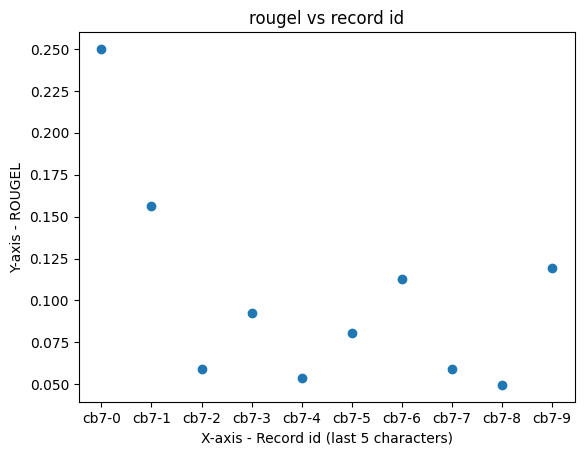

In [38]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougel, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGEL')
plt.title('rougel vs record id')

# Display the graph
plt.show()

Plot rougelsum metrics against records

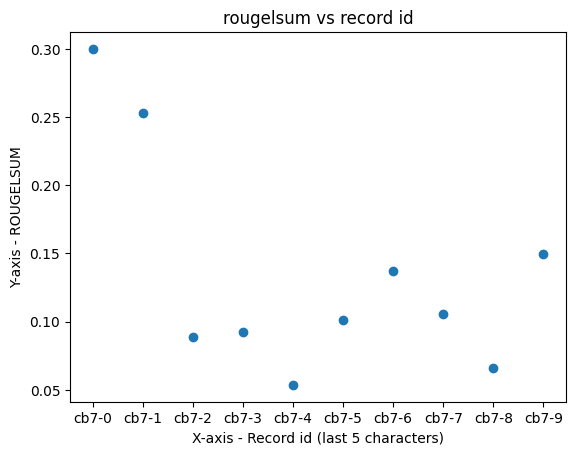

In [39]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougelsum, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGELSUM')
plt.title('rougelsum vs record id')

# Display the graph
plt.show()

# See factsheets information <a name="factsheetsspace"></a>

In [40]:
if not use_cpd:
    factsheets_url = "https://dataplatform.cloud.ibm.com/wx/prompt-details/{}/factsheet?context=wx&project_id={}".format(project_pta_id, project_id)
else:
    factsheets_url = factsheets_url = "{}/wx/prompt-details/{}/factsheet?context=wx&project_id={}".format(WML_CREDENTIALS["url"],project_pta_id, project_id)
print("User can navigate to the published facts in project {}".format(factsheets_url))

User can navigate to the published facts in project https://dataplatform.cloud.ibm.com/wx/prompt-details/73dd23b8-c255-48e4-8abe-fd3bfeb13336/factsheet?context=wx&project_id=2ee97ecb-f652-41a9-b360-dd2a7d594a8b


# Evaluate Prompt template from space <a name="evaluatespace"></a>

Here is a quick recap of what we have done so far.

1. We've created a prompt template asset in project.
2. We've created a `development` type subscription of prompt template asset in OpenScale.
3. Configured monitors supported by OpenScale for the subscriptions.
4. We've performed risk evaluations against the PTA susbscription with a sample set of test data.
5. Displayed the metrics generated with the risk evaluation.
6. Displayed the factsheets information for the subscription.

Now, we can promote the created prompt template asset to space and perform similar actions.

# Promote PTA to space <a name="promottospace"></a> 

Below cell promotes the prompt template asset from the project to the space.

In [41]:
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)
verify = True
if use_cpd:
    DATAPLATFORM_URL = WOS_CREDENTIALS["url"]
    verify = False
url = "{}/v2/assets/{}/promote".format(DATAPLATFORM_URL ,project_pta_id)

params = {
    "project_id":project_id
}

payload = {
    "space_id": space_id
}
response = requests.post(url, json=payload, headers=headers, params = params, verify = verify)
json_data = response.json()
space_pta_id = json_data["metadata"]["asset_id"]
space_pta_id

'98f6d104-7d2f-416a-bf76-c5c1b7c1149d'

# Create deployment for prompt template asset in space <a name="ptadeployment"></a>

To create a subscription from space, it is necessary to create a deployment for prompt template assets in spaces.

In [42]:
DEPLOYMENTS_URL = WML_CREDENTIALS["url"] + "/ml/v4/deployments"

serving_name = "summary_deployment_xgov1" # eg: summary_deployment

payload = {
    "prompt_template": {
      "id": space_pta_id
    },
    "online": {
       "parameters": {
         "serving_name": serving_name
       }
    },
    "base_model_id": "mistralai/mistral-large",
    "description": "summarization deployment",
    "name": "summarization deployment",
    "space_id": space_id
}

version = "2023-07-07" # The version date for the API of the form YYYY-MM-DD. Example : 2023-07-07
params = {
    "version":version,
    "space_id":space_id
}

response = requests.post(DEPLOYMENTS_URL, json=payload, headers=headers, params = params, verify = verify)
json_data = response.json()


if "metadata" in json_data:
    deployment_id = json_data["metadata"]["id"]
    print(deployment_id)
else:
    print(json_data)

ebe4d769-2940-4ff3-88d8-edfc271b4fb3


# Setup the prompt template asset in space for evaluation with supported monitor dimensions <a name="ptaspace"></a>

The prompt template assets from space is only supported with [`pre_production` and `production`] operational space IDs. Running the below cell will create a `production` type subscription from the prompt template asset promoted to the space. The `problem_type` value should depend on the task type specified in the prompt template asset.

In [43]:
space_pta_id = ''
space_id = ""
deployment_id = ""

In [44]:
label_column = "reference_summary"
operational_space_id = "production"
problem_type= "summarization"
input_data_type= "unstructured_text"

monitors = {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 10,
            "metrics_configuration":{        
            }
        }
    },
    "drift_v2": {
        "thresholds": [
            {
                "metric_id": "confidence_drift_score",
                "type": "upper_limit",
                "value": 0.05
            },
            {
                "metric_id": "prediction_drift_score",
                "type": "upper_limit",
                "value": 0.05
            },
            {
                "metric_id": "input_metadata_drift_score",
                "specific_values": [
                    {
                        "applies_to": [
                            {
                                "type": "tag",
                                "value": "subscription",
                                "key": "field_type"
                            }
                        ],
                        "value": 0.05
                    }
                ],
                "type": "upper_limit"
            },
            {
                "metric_id": "output_metadata_drift_score",
                "specific_values": [
                    {
                        "applies_to": [
                            {
                                "type": "tag",
                                "value": "subscription",
                                "key": "field_type"
                            }
                        ],
                        "value": 0.05
                    }
                ],
                "type": "upper_limit"
            }
        ],
        "parameters": {
            "min_samples": 10,
            "train_archive": True
        }
    }
}


response = wos_client.wos.execute_prompt_setup(prompt_template_asset_id = space_pta_id, 
                                                                   space_id = space_id,
                                                                   deployment_id = deployment_id,
                                                                   label_column = label_column, 
                                                                   operational_space_id = operational_space_id, 
                                                                   problem_type = problem_type,
                                                                   input_data_type = input_data_type, 
                                                                   supporting_monitors = monitors, 
                                                                   background_mode = False)

result = response.result
result._to_dict()




 Waiting for end of adding prompt setup 98f6d104-7d2f-416a-bf76-c5c1b7c1149d 




running..
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '98f6d104-7d2f-416a-bf76-c5c1b7c1149d',
 'space_id': '888ea269-8065-4573-b755-30e6ab163afc',
 'deployment_id': 'ebe4d769-2940-4ff3-88d8-edfc271b4fb3',
 'service_provider_id': '01999daf-32a1-7972-a6c9-e8e0fa9a6d2a',
 'subscription_id': '01999ea4-4392-7310-82bc-62dde8040c2f',
 'mrm_monitor_instance_id': '01999ea4-7e98-7cd5-a3cc-df627877b322',
 'start_time': '2025-10-01T07:19:47.548186Z',
 'end_time': '2025-10-01T07:20:10.782688Z',
 'status': {'state': 'FINISHED'}}

With the below cell, users can read the prompt setup task and check its status

In [45]:
response = wos_client.wos.get_prompt_setup(prompt_template_asset_id = space_pta_id,
                                                             deployment_id = deployment_id,
                                                             space_id = space_id)

result = response.result
result_json = result._to_dict()
result_json

{'prompt_template_asset_id': '98f6d104-7d2f-416a-bf76-c5c1b7c1149d',
 'space_id': '888ea269-8065-4573-b755-30e6ab163afc',
 'deployment_id': 'ebe4d769-2940-4ff3-88d8-edfc271b4fb3',
 'service_provider_id': '01999daf-32a1-7972-a6c9-e8e0fa9a6d2a',
 'subscription_id': '01999ea4-4392-7310-82bc-62dde8040c2f',
 'mrm_monitor_instance_id': '01999ea4-7e98-7cd5-a3cc-df627877b322',
 'start_time': '2025-10-01T07:19:47.548186Z',
 'end_time': '2025-10-01T07:20:10.782688Z',
 'status': {'state': 'FINISHED'}}

### Read subscription id from prompt setup

Once prompt setup status is finished, Read the subscription id from it.

In [46]:
prod_subscription_id = result_json["subscription_id"]
prod_subscription_id

'01999ea4-4392-7310-82bc-62dde8040c2f'

### Score the PTA deployment

Retrieve the scoring URL of the deployment from the subscription details.

In [47]:
sub_details = wos_client.subscriptions.get(prod_subscription_id).result
sub_details = sub_details._to_dict()
scoring_url = sub_details["entity"]["deployment"]["url"]
if not scoring_url.find("?version=") != -1:
    scoring_url = scoring_url.strip() + "?version=2023-09-07"

if use_cpd:
    scoring_url = WML_CREDENTIALS["url"] + "/ml/v1-beta/deployments/"+ deployment_id +"/generation/text?version=2023-09-07"
print(scoring_url)

https://us-south.ml.cloud.ibm.com/ml/v1/deployments/ebe4d769-2940-4ff3-88d8-edfc271b4fb3/text/generation?version=2023-09-07


# Score the model so that we can configure monitors <a name="score"></a>

Now that the WML service has been bound and the subscription has been created, we need to score the prompt template asset. User needs to generate the test data content in JSON format from the downloaded CSV file. This is used to construct the payload for scoring the deployment.

In [48]:
import csv

feature_fields = ["original_text"]
prediction = "generated_text"

headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

pl_data = []
prediction_list = []
with open(test_data_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        request = {
            "parameters": {
                "template_variables": {
                }
            }
        }
        for each in feature_fields:
            request["parameters"]["template_variables"][each] = str(row[each])

        response = requests.post(scoring_url, json=request, headers=headers, verify=False).json()
        predicted_val = response["results"][0][prediction]
        prediction_list.append(predicted_val)
        record = {"request":request, "response":response}
        pl_data.append(record)
    
pl_data

[{'request': {'parameters': {'template_variables': {'original_text': 'by using our services you are agreeing to these terms our trainer guidelines and our privacy policy. if you are the parent or legal guardian of a child under the age of 13 the parent you are agreeing to these terms on behalf of yourself and your child ren who are authorized to use the services pursuant to these terms and in our privacy policy. if you don t agree to these terms our trainer guidelines and our privacy policy do not use the services.'}}},
  'response': {'model_id': 'mistralai/mistral-large',
   'model_version': '2.0.0',
   'created_at': '2025-10-01T07:20:18.564Z',
   'results': [{'generated_text': " By using our services, you agree to our Terms, Trainer Guidelines, and Privacy Policy. If you're a parent or legal guardian of a child under 13, you're agreeing to these terms on behalf of yourself and your child(ren) who are authorized to use the services. If you don't agree to these terms, guidelines, and p

### Generating additional payload data to enable drift

To enable drift there should be minimum 100 records in the payload table. The below cell duplicates the scored records and create another 100 records for adding to the payload table

In [49]:
import copy

additional_pl_data = copy.copy(pl_data)
additional_pl_data *= 10
print("Generated {} additional payload data".format(len(additional_pl_data)))

Generated 100 additional payload data


### Adding payload data

Below cell reads the payload data set id from the subscription. 

In [50]:
import time
from ibm_watson_openscale.supporting_classes.enums import *

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=prod_subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

Payload data set id:  01999ea4-578b-752e-a7bf-372d47f82fa4


Add additioanl payload data to enable drift V2

In [51]:
wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=additional_pl_data,background_mode=False)
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))




 Waiting for end of storing records with request id: dbafb91b-51f3-4316-b254-c3408aa79b1b 




pending...
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the payload logging table: 100


Now a total of 110 records should be available within the payload table. But in case if auto payload logging fails to transmit the scored records to the payload logging table, the following code can be used to manually add payload data to the table.

In [52]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))
if pl_records_count < 110:
    print("Payload logging did not happen, performing explicit payload logging.")
    wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=pl_data,background_mode=False)
    time.sleep(5)
    pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
    print("Number of records in the payload logging table: {}".format(pl_records_count))

Number of records in the payload logging table: 100
Payload logging did not happen, performing explicit payload logging.



 Waiting for end of storing records with request id: 92f620e6-1d7e-44ec-9295-e63917c70b59 




pending
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the payload logging table: 110


### Adding feedback data

Below cell reads the feedback data set id from the subscription. 

In [53]:
import time
from ibm_watson_openscale.supporting_classes.enums import *

time.sleep(5)
feedback_data_set_id = None
feedback_data_set_id = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=prod_subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if feedback_data_set_id is None:
    print("Feedback data set not found. Please check subscription status.")
else:
    print("Feedback data set id: ", feedback_data_set_id)

Feedback data set id:  01999ea4-6645-7e25-b87f-d28f27ca0ab8


The provided code generates feedback data based on the downloaded CSV file and the scored response.

In [55]:
import csv

test_data_content = []
csv_file_path = "summarisation.csv"

with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row, prediction_val in zip(csv_reader, prediction_list):

        # Read each row from the CSV and add label and prediction values
        result_row = []
        result_row = [row[key] for key in feature_fields if key in row]
        result_row.append(row[label_column])
        result_row.append(prediction_val)
        test_data_content.append(result_row)

if len(test_data_content) == 10: # 10 records are there in the downloaded CSV
    print("generated feedback data from CSV")
else:
    print("Failed to generated feedback data from CSV, Kindly verify the CSV file content")

generated feedback data from CSV


In [56]:
fields = feature_fields
fields.append(label_column)
fields.append("_original_prediction")
feedback_data = [
    {
        "fields": fields,
        "values": test_data_content
    }
]
feedback_data

[{'fields': ['original_text', 'reference_summary', '_original_prediction'],
  'values': [['by using our services you are agreeing to these terms our trainer guidelines and our privacy policy. if you are the parent or legal guardian of a child under the age of 13 the parent you are agreeing to these terms on behalf of yourself and your child ren who are authorized to use the services pursuant to these terms and in our privacy policy. if you don t agree to these terms our trainer guidelines and our privacy policy do not use the services.',
    'by playing this game you agree to these terms. if you re under 13 and playing your parent guardian agrees on your behalf.',
    " By using our services, you agree to our Terms, Trainer Guidelines, and Privacy Policy. If you're a parent or legal guardian of a child under 13, you're agreeing to these terms on behalf of yourself and your child(ren) who are authorized to use the services. If you don't agree to these terms, guidelines, and policy, plea

The following code can be used to manually add feedback data to the table.

In [57]:
wos_client.data_sets.store_records(data_set_id=feedback_data_set_id, request_body=feedback_data,background_mode=False)
time.sleep(5)
fb_records_count = wos_client.data_sets.get_records_count(feedback_data_set_id)
# Adding time delay to enable drift
time.sleep(10)
print("Number of records in the feedback logging table: {}".format(fb_records_count))




 Waiting for end of storing records with request id: e972a8e5-d37c-4402-898e-b755a407743a 




active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the feedback logging table: 10


## Show all the monitor instances of the production subscription
The following cell lists the monitors present in the production subscription along with their respective statuses and other details. Please wait for all the monitors to be in active state before proceeding further.

In [58]:
wos_client.monitor_instances.show(target_target_id = prod_subscription_id)

2c08665d-dacd-4fe2-9035-6963dc3fb1a4,active,01999ea4-4392-7310-82bc-62dde8040c2f,subscription,generative_ai_quality,2025-10-01 07:19:59.732000+00:00,01999ea4-6827-7835-ba2c-307593f0df7c
2c08665d-dacd-4fe2-9035-6963dc3fb1a4,active,01999ea4-4392-7310-82bc-62dde8040c2f,subscription,model_health,2025-10-01 07:20:03.725000+00:00,01999ea4-7908-74e1-8131-d97fff0e64d6
2c08665d-dacd-4fe2-9035-6963dc3fb1a4,preparing,01999ea4-4392-7310-82bc-62dde8040c2f,subscription,drift_v2,2025-10-01 07:20:02.229000+00:00,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe
2c08665d-dacd-4fe2-9035-6963dc3fb1a4,active,01999ea4-4392-7310-82bc-62dde8040c2f,subscription,mrm,2025-10-01 07:20:05.116000+00:00,01999ea4-7e98-7cd5-a3cc-df627877b322


### Read the MRM monitor instance ID of PTA subscription deployed in space

Evaluating the test data against the prompt template subscription requires the monitor instance ID of MRM.

In [59]:
monitor_definition_id = "mrm"
target_target_id = prod_subscription_id
result = wos_client.monitor_instances.list(data_mart_id=data_mart_id,
                                           monitor_definition_id=monitor_definition_id,
                                           target_target_id=target_target_id,
                                           space_id=space_id).result
result_json = result._to_dict()
mrm_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
mrm_monitor_id

'01999ea4-7e98-7cd5-a3cc-df627877b322'

### Evaluate the prompt template subscription from space

The following cell will assess subscription of the prompt template asset and produce relevant measurements for the configured monitor. The data to be evaluated are already uploaded to payload and feedback table.

In [60]:
response  = wos_client.monitor_instances.mrm.evaluate_risk(monitor_instance_id=mrm_monitor_id, 
                                                    body = body,
                                                    space_id = space_id,
                                                    evaluation_tests = ["model_health", "drift_v2", "generative_ai_quality"],
                                                    background_mode = False)




 Waiting for risk evaluation of MRM monitor 01999ea4-7e98-7cd5-a3cc-df627877b322 




running.............
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




### Read the risk evaluation response

After initiating the risk evaluation, the evaluation results of PTA from space are now available for review,

In [61]:
response  = wos_client.monitor_instances.mrm.get_risk_evaluation(mrm_monitor_id, space_id = space_id)
response.result.to_dict()

{'metadata': {'id': 'b2038d21-e8ba-45fd-b4eb-f174ab6f3b30',
  'created_at': '2025-10-01T07:22:44.824Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'deployment_id': 'ebe4d769-2940-4ff3-88d8-edfc271b4fb3',
   'evaluation_start_time': '2025-10-01T07:22:42.694649Z',
   'facts': {'state': 'finished'},
   'measurement_id': '01999ea6-f12d-72ee-b54e-3b3c0b01e06e',
   'monitors_run_status': [{'monitor_id': 'generative_ai_quality',
     'status': {'reason': {'code': 'AIQGA1011E',
       'message': 'Generative AI Quality monitor evaluation failed. Failed to evaluate metrics using metrics_compute service for monitor instance 01999ea4-6827-7835-ba2c-307593f0df7c of subscription 01999ea4-4392-7310-82bc-62dde8040c2f. Error: {"error":"Cannot copy out of meta tensor; no data! Please use torch.nn.Module.to_empty() instead of torch.nn.Module.to() when moving module from meta to a different device."}\n.',
       'trace': 'mon

## Display the Model Risk metrics

Having calculated the measurements for the Foundation Model subscription, the MRM metrics generated for this subscription are now available for your review.

In [62]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mrm_monitor_id, space_id=space_id)

2025-10-01 07:22:44.909000+00:00,tests_passed,01999ea6-f12d-72ee-b54e-3b3c0b01e06e,0.0,None,None,[],mrm,01999ea4-7e98-7cd5-a3cc-df627877b322,b2038d21-e8ba-45fd-b4eb-f174ab6f3b30,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:44.909000+00:00,tests_run,01999ea6-f12d-72ee-b54e-3b3c0b01e06e,2.0,None,None,[],mrm,01999ea4-7e98-7cd5-a3cc-df627877b322,b2038d21-e8ba-45fd-b4eb-f174ab6f3b30,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:44.909000+00:00,tests_skipped,01999ea6-f12d-72ee-b54e-3b3c0b01e06e,3.0,None,None,[],mrm,01999ea4-7e98-7cd5-a3cc-df627877b322,b2038d21-e8ba-45fd-b4eb-f174ab6f3b30,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:44.909000+00:00,tests_failed,01999ea6-f12d-72ee-b54e-3b3c0b01e06e,2.0,None,None,[],mrm,01999ea4-7e98-7cd5-a3cc-df627877b322,b2038d21-e8ba-45fd-b4eb-f174ab6f3b30,subscription,01999ea4-4392-7310-82bc-62dde8040c2f


## Display the Generative AI Quality metrics

### Read the Generative ai quality monitor instance id

Monitor instance ID of Generative ai quality metrics is required for reading its metrics.

In [63]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           space_id = space_id).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'01999ea4-6827-7835-ba2c-307593f0df7c'

Displaying the monitor metrics of GenAIQ generated through the risk evaluation.

In [64]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=genaiquality_monitor_id, space_id=space_id)

2025-10-01 07:22:23.713035+00:00,flesch_reading_ease,01999ea6-9e61-7162-a1ce-bec9b6818fe8,47.852,60.0,None,"['computed_on:payload_logging', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea4-6827-7835-ba2c-307593f0df7c,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:23.713035+00:00,records_processed,01999ea6-9e61-7162-a1ce-bec9b6818fe8,110.0,None,None,"['computed_on:payload_logging', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea4-6827-7835-ba2c-307593f0df7c,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:23.713035+00:00,compression,01999ea6-9e61-7162-a1ce-bec9b6818fe8,2.8169,None,None,"['computed_on:payload_logging', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea4-6827-7835-ba2c-307593f0df7c,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:23.713035+00:00,repetitiveness,01999ea6-9e61-7162-a1ce-bec9b6818fe8,0.1338,None,0.2,"['computed_on:payload_logging', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea4-6827-7835-ba2c-307593f0df7c,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:23.713035+00:00,coverage,01999ea6-9e61-7162-a1ce-bec9b6818fe8,0.6048,0.7,None,"['computed_on:payload_logging', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea4-6827-7835-ba2c-307593f0df7c,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:23.713035+00:00,density,01999ea6-9e61-7162-a1ce-bec9b6818fe8,0.0165,None,None,"['computed_on:payload_logging', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea4-6827-7835-ba2c-307593f0df7c,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:23.713035+00:00,abstractness,01999ea6-9e61-7162-a1ce-bec9b6818fe8,0.3951,None,0.2,"['computed_on:payload_logging', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,01999ea4-6827-7835-ba2c-307593f0df7c,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:23.713035+00:00,flesch_reading_ease,01999ea6-9e61-7162-a1ce-bec9b6818fe8,8.64,60.0,None,"['computed_on:payload_logging', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,01999ea4-6827-7835-ba2c-307593f0df7c,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:23.713035+00:00,records_processed,01999ea6-9e61-7162-a1ce-bec9b6818fe8,110.0,None,None,"['computed_on:payload_logging', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,01999ea4-6827-7835-ba2c-307593f0df7c,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:23.713035+00:00,compression,01999ea6-9e61-7162-a1ce-bec9b6818fe8,1.026,None,None,"['computed_on:payload_logging', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,01999ea4-6827-7835-ba2c-307593f0df7c,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,subscription,01999ea4-4392-7310-82bc-62dde8040c2f


Note: First 10 records were displayed.


## Display record level metrics for Generative AI Quality 

Read the dataset id for generative ai quality dataset

In [65]:
result = wos_client.data_sets.list(target_target_id = prod_subscription_id,
                                target_target_type = "subscription",
                                type = "gen_ai_quality_metrics").result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'01999ea4-733a-7ac6-ac76-fcdf51991522'

Displaying record level metrics for generative ai quality

In [66]:
wos_client.data_sets.show_records(data_set_id = genaiq_dataset_id)

35.27,None,None,None,None,447b3db6-3d83-455e-9d24-d689f979d1ca-1,None,payload_logging,2025-10-01T07:21:09.003766Z,None,None,2025-10-01T07:22:24.376743Z,1.026,0.0862,None,0.7215,None,None,None,None,None,None,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,None,0.0288,None,None,None,0.4483,None,None,None,None,None,None
57.16,None,None,None,None,9e62fe24-98cd-4bef-b7a5-2694166791b3-1,None,payload_logging,2025-10-01T07:21:09.004014Z,None,None,2025-10-01T07:22:24.376719Z,4.4472,0.1197,None,0.5768,None,None,None,None,None,None,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,None,0.0126,None,None,None,0.2817,None,None,None,None,None,None
35.27,None,None,None,None,5ac1aea8-44ba-4a9e-8605-22d3d4b00df3-1,None,payload_logging,2025-10-01T07:21:09.004056Z,None,None,2025-10-01T07:22:24.376697Z,1.026,0.0862,None,0.7215,None,None,None,None,None,None,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,None,0.0288,None,None,None,0.4483,None,None,None,None,None,None
35.27,None,None,None,None,1d8b25af-243c-464f-a68c-563500c42d5d-1,None,payload_logging,2025-10-01T07:21:10.879549Z,None,None,2025-10-01T07:22:24.376673Z,1.026,0.0862,None,0.7215,None,None,None,None,None,None,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,None,0.0288,None,None,None,0.4483,None,None,None,None,None,None
65.42,None,None,None,None,f23e096c-59fb-41a7-857c-2a9387d62a98-1,None,payload_logging,2025-10-01T07:21:10.879749Z,None,None,2025-10-01T07:22:24.376650Z,3.5585,0.122,None,0.5247,None,None,None,None,None,None,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,None,0.008,None,None,None,0.3821,None,None,None,None,None,None
39.94,None,None,None,None,3ee377e8-2aea-48cc-9eb0-91c4db43a93a-1,None,payload_logging,2025-10-01T07:21:10.879789Z,None,None,2025-10-01T07:22:24.376627Z,1.6987,0.1088,None,0.6717,None,None,None,None,None,None,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,None,0.0096,None,None,None,0.3469,None,None,None,None,None,None
50.23,None,None,None,None,462cbeca-d4cd-453d-9805-eab72415b813-1,None,payload_logging,2025-10-01T07:21:10.879813Z,None,None,2025-10-01T07:22:24.376604Z,2.7818,0.1667,None,0.5207,None,None,None,None,None,None,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,None,0.0071,None,None,None,0.4412,None,None,None,None,None,None
50.33,None,None,None,None,3713b7cf-d086-4fbc-a1e7-f804e4967f75-1,None,payload_logging,2025-10-01T07:21:10.879837Z,None,None,2025-10-01T07:22:24.376580Z,3.6149,0.1579,None,0.5876,None,None,None,None,None,None,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,None,0.0098,None,None,None,0.4135,None,None,None,None,None,None
50.23,None,None,None,None,600b6ba2-c763-418d-a573-5a5acf2f54df-1,None,payload_logging,2025-10-01T07:21:10.879862Z,None,None,2025-10-01T07:22:24.376557Z,2.7818,0.1667,None,0.5207,None,None,None,None,None,None,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,None,0.0071,None,None,None,0.4412,None,None,None,None,None,None
65.42,None,None,None,None,01073ac3-f36c-457e-ad98-d46e825b3e40-1,None,payload_logging,2025-10-01T07:21:12.246574Z,None,None,2025-10-01T07:22:24.376527Z,3.5585,0.122,None,0.5247,None,None,None,None,None,None,7aa53a37-2c76-4279-8dfc-f18dad4dcc79,None,0.008,None,None,None,0.3821,None,None,None,None,None,None


# Plot rougel and rougelsum metrics against records <a name="plotspace"></a>

In [67]:
result = wos_client.data_sets.get_list_of_records(data_set_id = genaiq_dataset_id).result
result["records"]
x = []
y_rougel = []
y_rougelsum = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:]) # Reading only last 5 characters to fit in the display
    y_rougel.append(each["entity"]["values"]["rougel"])
    y_rougelsum.append(each["entity"]["values"]["rougelsum"])

Plot rougel metrics against records

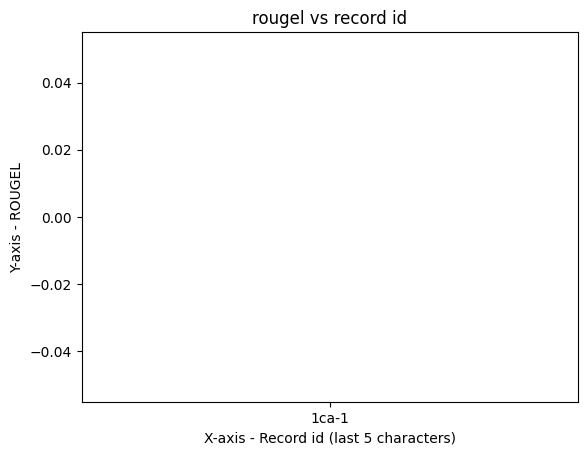

In [68]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougel, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGEL')
plt.title('rougel vs record id')

# Display the graph
plt.show()

Plot rougelsum metrics against records

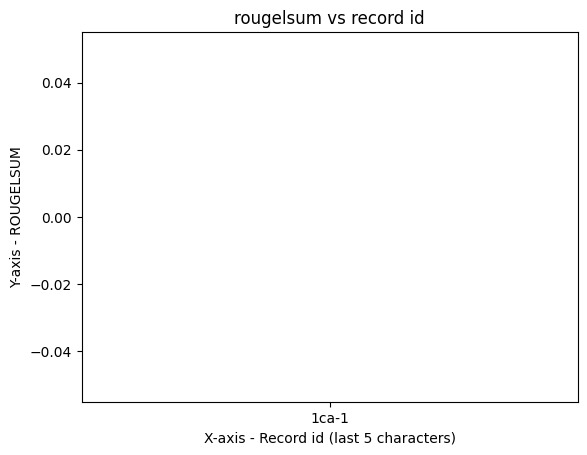

In [69]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougelsum, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGELSUM')
plt.title('rougelsum vs record id')

# Display the graph
plt.show()

## Display the Drift V2 metrics

### Read the Drift V2 monitor instance id

Monitor instance ID of Drift V2 metrics is required for reading its metrics.

In [70]:
monitor_definition_id = "drift_v2"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           space_id = space_id).result
result_json = result._to_dict()
drift_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
drift_monitor_id

'01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe'

Displaying the monitor metrics of Drift V2 generated through the risk evaluation.

In [71]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=drift_monitor_id, space_id=space_id)

2025-10-01 07:23:18.248380+00:00,records_processed,01999ea7-7368-70c5-bc1d-fe868596b102,10.0,None,None,"['algorithm_used:total_variation', 'computed_on:payload', 'field_type:input_meta', 'field_name:wos_input_character_count__']",drift_v2,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe,b1663c02-a764-4287-b7e2-66c5a6965ce8,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:23:18.248380+00:00,input_metadata_drift_score,01999ea7-7368-70c5-bc1d-fe868596b102,0.3907,None,None,"['algorithm_used:total_variation', 'computed_on:payload', 'field_type:input_meta', 'field_name:wos_input_character_count__']",drift_v2,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe,b1663c02-a764-4287-b7e2-66c5a6965ce8,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:23:18.248380+00:00,records_processed,01999ea7-7368-70c5-bc1d-fe868596b102,10.0,None,None,"['algorithm_used:overlap_coefficient', 'computed_on:payload', 'field_type:input_meta', 'field_name:wos_input_character_count__']",drift_v2,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe,b1663c02-a764-4287-b7e2-66c5a6965ce8,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:23:18.248380+00:00,input_metadata_drift_score,01999ea7-7368-70c5-bc1d-fe868596b102,0.3942,None,None,"['algorithm_used:overlap_coefficient', 'computed_on:payload', 'field_type:input_meta', 'field_name:wos_input_character_count__']",drift_v2,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe,b1663c02-a764-4287-b7e2-66c5a6965ce8,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:23:29.229488+00:00,records_processed,01999ea7-9e4d-7c82-aaa7-0eb3464f67c7,10.0,None,None,"['algorithm_used:total_variation', 'computed_on:payload', 'field_type:input_meta', 'field_name:wos_input_word_count__']",drift_v2,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe,b1663c02-a764-4287-b7e2-66c5a6965ce8,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:23:29.229488+00:00,input_metadata_drift_score,01999ea7-9e4d-7c82-aaa7-0eb3464f67c7,0.2931,None,None,"['algorithm_used:total_variation', 'computed_on:payload', 'field_type:input_meta', 'field_name:wos_input_word_count__']",drift_v2,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe,b1663c02-a764-4287-b7e2-66c5a6965ce8,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:23:29.229488+00:00,records_processed,01999ea7-9e4d-7c82-aaa7-0eb3464f67c7,10.0,None,None,"['algorithm_used:overlap_coefficient', 'computed_on:payload', 'field_type:input_meta', 'field_name:wos_input_word_count__']",drift_v2,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe,b1663c02-a764-4287-b7e2-66c5a6965ce8,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:23:29.229488+00:00,input_metadata_drift_score,01999ea7-9e4d-7c82-aaa7-0eb3464f67c7,0.2972,None,None,"['algorithm_used:overlap_coefficient', 'computed_on:payload', 'field_type:input_meta', 'field_name:wos_input_word_count__']",drift_v2,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe,b1663c02-a764-4287-b7e2-66c5a6965ce8,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:23:37.025791+00:00,records_processed,01999ea7-bcc1-79e3-b468-45ad4f731e20,10.0,None,None,"['algorithm_used:total_variation', 'computed_on:payload', 'field_type:input_meta', 'field_name:wos_input_sentence_count__']",drift_v2,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe,b1663c02-a764-4287-b7e2-66c5a6965ce8,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:23:37.025791+00:00,input_metadata_drift_score,01999ea7-bcc1-79e3-b468-45ad4f731e20,0.2421,None,None,"['algorithm_used:total_variation', 'computed_on:payload', 'field_type:input_meta', 'field_name:wos_input_sentence_count__']",drift_v2,01999ea4-6ec3-7b9f-9cb7-eb7432e85bbe,b1663c02-a764-4287-b7e2-66c5a6965ce8,subscription,01999ea4-4392-7310-82bc-62dde8040c2f


Note: First 10 records were displayed.


## Display the model health metrics
### Read the model health monitor instance id
Monitor instance ID of model health metrics is required for reading its metrics.

In [72]:
monitor_definition_id = "model_health"
target_target_id = prod_subscription_id
result = wos_client.monitor_instances.list(data_mart_id=data_mart_id,
                                           monitor_definition_id=monitor_definition_id,
                                           target_target_id=target_target_id,
                                           space_id=space_id).result
result_json = result._to_dict()
mhm_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
mhm_monitor_id

'01999ea4-7908-74e1-8131-d97fff0e64d6'

Displaying the monitor metrics of model health

In [73]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mhm_monitor_id, space_id=space_id)

2025-10-01 07:22:10.449198+00:00,total_records,01999ea6-6a91-7cb9-8f62-42c0390541bd,110.0,None,None,[],model_health,01999ea4-7908-74e1-8131-d97fff0e64d6,c0463214-370b-4616-8302-adb6ab0135f0,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:10.449198+00:00,median_input_token_count,01999ea6-6a91-7cb9-8f62-42c0390541bd,388.0,None,None,[],model_health,01999ea4-7908-74e1-8131-d97fff0e64d6,c0463214-370b-4616-8302-adb6ab0135f0,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:10.449198+00:00,average_output_token_count,01999ea6-6a91-7cb9-8f62-42c0390541bd,166.3,None,None,[],model_health,01999ea4-7908-74e1-8131-d97fff0e64d6,c0463214-370b-4616-8302-adb6ab0135f0,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:10.449198+00:00,minimum_output_token_count,01999ea6-6a91-7cb9-8f62-42c0390541bd,87.0,None,None,[],model_health,01999ea4-7908-74e1-8131-d97fff0e64d6,c0463214-370b-4616-8302-adb6ab0135f0,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:10.449198+00:00,total_scoring_requests,01999ea6-6a91-7cb9-8f62-42c0390541bd,110.0,None,None,[],model_health,01999ea4-7908-74e1-8131-d97fff0e64d6,c0463214-370b-4616-8302-adb6ab0135f0,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:10.449198+00:00,median_records,01999ea6-6a91-7cb9-8f62-42c0390541bd,1.0,None,None,[],model_health,01999ea4-7908-74e1-8131-d97fff0e64d6,c0463214-370b-4616-8302-adb6ab0135f0,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:10.449198+00:00,average_input_token_count,01999ea6-6a91-7cb9-8f62-42c0390541bd,494.3,None,None,[],model_health,01999ea4-7908-74e1-8131-d97fff0e64d6,c0463214-370b-4616-8302-adb6ab0135f0,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:10.449198+00:00,maximum_input_token_count,01999ea6-6a91-7cb9-8f62-42c0390541bd,1074.0,None,None,[],model_health,01999ea4-7908-74e1-8131-d97fff0e64d6,c0463214-370b-4616-8302-adb6ab0135f0,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:10.449198+00:00,median_output_token_count,01999ea6-6a91-7cb9-8f62-42c0390541bd,183.0,None,None,[],model_health,01999ea4-7908-74e1-8131-d97fff0e64d6,c0463214-370b-4616-8302-adb6ab0135f0,subscription,01999ea4-4392-7310-82bc-62dde8040c2f
2025-10-01 07:22:10.449198+00:00,total_output_token_count,01999ea6-6a91-7cb9-8f62-42c0390541bd,18293.0,None,None,[],model_health,01999ea4-7908-74e1-8131-d97fff0e64d6,c0463214-370b-4616-8302-adb6ab0135f0,subscription,01999ea4-4392-7310-82bc-62dde8040c2f


Note: First 10 records were displayed.


# User can navigate to see the published facts in space <a name="factsheetsproject"></a>

In [74]:
if not use_cpd:
    factsheets_url = "https://dataplatform.cloud.ibm.com/ml-runtime/deployments/{}/details?space_id={}&context=wx&flush=true".format(deployment_id, space_id)
else:
    factsheets_url = "{}/ml-runtime/deployments/{}/details?space_id={}&context=wx&flush=true".format(WML_CREDENTIALS["url"], deployment_id, space_id)
    
print("User can navigate to the published facts in space {}".format(factsheets_url))

User can navigate to the published facts in space https://dataplatform.cloud.ibm.com/ml-runtime/deployments/ebe4d769-2940-4ff3-88d8-edfc271b4fb3/details?space_id=888ea269-8065-4573-b755-30e6ab163afc&context=wx&flush=true


## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now navigate to the prompt template asset in your project / spaceand click on the Evaluate tab to visualise the results on the UI.